In [14]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

import src.helpers.model_helpers as mh
from sklearn.model_selection import StratifiedKFold
import src.helpers.feature_engineering_helper as feh
import src.helpers.logistic_regression_helpers as lrh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [16]:
# Log transform skewed continuous features prior to scaling
X_train = feh.log_transform_skewed_features(X_train)
X_test = feh.log_transform_skewed_features(X_test)

# Scale numeric features prior to training
lrh.scale_dataset(X_train)
lrh.scale_dataset(X_test)

,loan_amount,income,combined_loan_to_value_ratio,loan_term,intro_rate_period,prepayment_penalty_term,property_value
4048597,0.531789,0.076205,0.325896,0.470346,-0.162348,0.077177,0.035049
5573908,0.314341,-0.372218,0.700523,0.470346,-0.162348,0.077177,-0.506020
2074066,-0.078076,-0.160420,-0.583604,-0.990667,-0.162348,0.077177,0.884289
4749255,1.195145,0.177574,0.700523,0.470346,-0.162348,0.077177,0.692219
5863718,0.354053,0.114174,0.301038,-0.260161,-0.162348,0.077177,-0.506020
...,...,...,...,...,...,...,...
4059493,-0.526748,-1.151858,0.852714,0.470346,-0.162348,0.077177,-1.551868
7224571,-0.140138,0.565258,-1.124668,0.470346,-0.162348,0.077177,1.790152
8489849,-0.078076,0.026789,0.298504,-0.990667,-0.162348,0.077177,-0.270869
3149049,-0.353673,1.120435,0.382068,-1.721174,-0.162348,0.077177,1.019980


In [17]:
# Create logistic regression search without PCA
search_without_pca = lrh.create_cv_search()
base_log_reg = lrh.create_base_estimator()

search_without_pca.fit(X_train, y_train)

/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setup

,estimator,"LogisticRegre...a', tol=0.001)"
,param_distributions,"{'C': <scipy.stats....t 0x12bb034d0>, 'class_weight': [None, 'balanced'], 'l1_ratio': <scipy.stats....t 0x12c7d16e0>}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [18]:
# Create logistic regression search with PCA
search_with_pca = lrh.create_cv_search()

# Transform training data for PCA
X_train_pca = lrh.scale_dataset(X_train)

search_with_pca.fit(X_train_pca, y_train)

,estimator,"LogisticRegre...a', tol=0.001)"
,param_distributions,"{'C': <scipy.stats....t 0x12c7d1480>, 'class_weight': [None, 'balanced'], 'l1_ratio': <scipy.stats....t 0x12bb1da30>}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [19]:
# Calculate F1 for validation
print("Without PCA")
mh.output_cv_summary(search_without_pca)

print("With PCA")
mh.output_cv_summary(search_with_pca)

Without PCA
Best params: {'C': np.float64(42.78743516759822), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.18182496720710062)}
Best CV F1: 0.5957961073653345
With PCA
Best params: {'C': np.float64(42.78743516759822), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.18182496720710062)}
Best CV F1: 0.460254034426725


In [20]:
# Calculate metrics without PCA
results, y_pred, y_prob = mh.calculate_test_metrics(search_without_pca, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "log_reg_metrics_csv")

# Display metrics
print("Test Performance (Without PCA):")
display(results)

Test Performance (Without PCA):


,Score
F1,0.594978
Accuracy,0.759162
Precision,0.497878
Recall,0.739130
ROC AUC,0.831442
PR AUC,0.641836


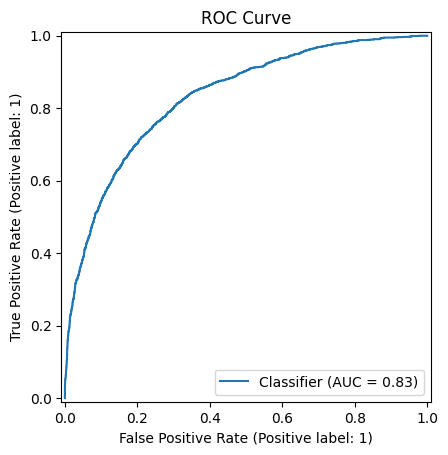

In [22]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "log_reg_roc")

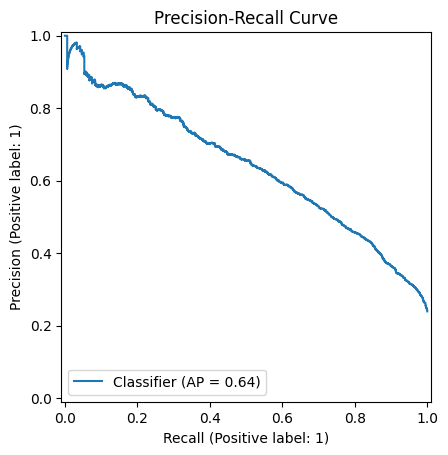

In [23]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "log_reg_pr")

In [24]:
# Persist fitted model
mh.persist_model(search_without_pca, "log_reg_model")

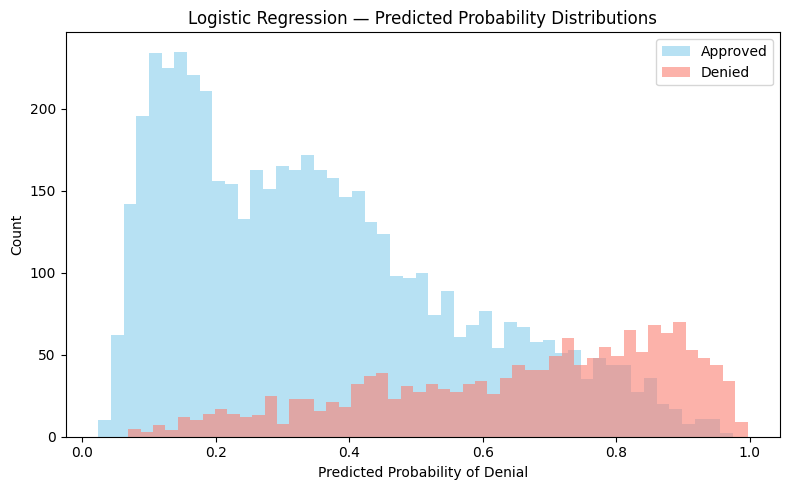

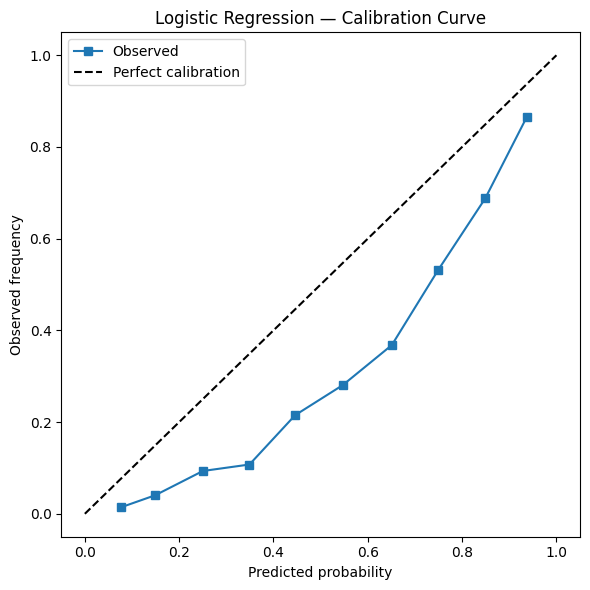

In [25]:
# Plot diagnostic charts to see how to further optimize model
mh.plot_probability_distributions(y_test, y_prob, "Logistic Regression")
mh.plot_calibration_curve(y_test, y_prob, "Logistic Regression")